In this notebook, we are going to load some of the data that we processed in the Condensed Notebook and perform within-trial analysis of the oscillation bursts using eBOSC, a sliding window PSD peak detector thresholded against the data. 

In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [55]:
import numpy as np
import mne
import mne_connectivity
import pactools
from mne_connectivity import phase_slope_index, seed_target_indices, spectral_connectivity_epochs
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
# Import plotting functions
from fooof.plts.spectra import plot_spectrum, plot_spectra
# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup
import os 
import joblib
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 

# I only want to see warnings once
warnings.filterwarnings('ignore')

from joblib import delayed, Parallel
from statsmodels.stats import multitest

Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [7]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [17]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, oscillation_utils, statistics_utils


In [18]:
import h5io

## First, get the behavior data

This is from another notebook with a kernel and environment specifically for beahvior

In [12]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results
load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU'

# Load the demographics data to get information about who has run the task
demo_file = f'{base_dir}/projects/guLab/Salman/EMU/MemoryBanditsDatabase.xlsx'
demo_data = pd.read_excel(demo_file, engine='openpyxl')
subj_df = demo_data[(demo_data.LongVersion==1) & (demo_data.Minerva==1)]

# Let's get rid of Iowa patients for now 

subj_df = subj_df[subj_df.Site!='UI']

days = ['Day1', 'Day2']
subj_ids = subj_df.MSSMCode.values
subj_formats = subj_df.format.values
subj_sites = subj_df.Site.values
subj_days = subj_df.Day2.values

In [62]:
# load behavioral data
learn_df = pd.read_csv(f'{load_dir}/learn_df.csv')
combined_df = pd.read_csv(f'{load_dir}/combined_df.csv')

# Filter just to the participants in this notebook
learn_df = learn_df[learn_df.participant.isin(subj_ids)]
combined_df = combined_df[combined_df.participant.isin(subj_ids)]


# I enter the day information in stupidly 
combined_df.condition = combined_df.condition.apply(lambda x: 'Day1' if x=='day_1' else 'Day2' if x=='day_2' else np.nan)
combined_df['recog_time'] = combined_df['recog_time'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)
combined_df['baseline_start_mem'] = combined_df['baseline_start_mem'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)

# # add RPE to the combined df dataframe: 

combined_df['rpe'] = np.nan
for ix, row in learn_df.iterrows():
    combined_df.loc[(combined_df.img_path==row.img_path) & (combined_df.participant==row.participant), 'rpe'] = row.rpe

In [36]:
dir(oscillation_utils)

['BOSC_detect',
 'BOSC_tf',
 'Path',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'chi2',
 'compute_connectivity',
 'compute_eBOSC_parallel',
 'eBOSC_episode_create',
 'eBOSC_episode_postproc_fwhm',
 'eBOSC_episode_postproc_maxbias',
 'eBOSC_episode_rm_shoulder',
 'eBOSC_episode_sparsefreq',
 'eBOSC_getThresholds',
 'eBOSC_wrapper',
 'find_nearest_value',
 'getTimeFromFTmat',
 'get_project_root',
 'mne',
 'np',
 'numpy',
 'pd',
 'phase_slope_index',
 'seed_target_indices',
 'sio',
 'sm',
 'spectral_connectivity_epochs',
 'swap_time_blocks',
 'tqdm',
 'zscore']

# eBOSC

eBOSC allows us to identify transient bursts

After epoching, we can compute the eBOSC, using the same frequency range we used for FOOOF. This is because both use line-fitting regiments for the PSD that tend to break down when higher frequencies are included. 

In [14]:
cfg_eBOSC = dict()
cfg_eBOSC['F'] = np.linspace(1,30, 44)   # frequency sampling
cfg_eBOSC['wavenumber'] = 6                   # wavelet parameter (time-frequency tradeoff)
cfg_eBOSC['fsample'] = 500 # current sampling frequency of EEG data
cfg_eBOSC['pad.tfr_s'] = 0                   #  padding following wavelet transform to avoid edge artifacts in seconds (bi-lateral)
cfg_eBOSC['pad.detection_s'] = 0             # padding following rhythm detection in seconds (bi-lateral); 'shoulder' for BOSC eBOSC.detected matrix to account for duration threshold
cfg_eBOSC['pad.background_s'] = 0             # padding of segments for BG (only avoiding edge artifacts)

cfg_eBOSC['threshold.excludePeak'] = np.array([])   # lower and upper bound of frequencies to be excluded during background fit (Hz) (previously: LowFreqExcludeBG HighFreqExcludeBG)
cfg_eBOSC['threshold.duration'] = np.kron(np.ones((1,len(cfg_eBOSC['F']))),3) # vector of duration thresholds at each frequency (previously: ncyc)
cfg_eBOSC['threshold.percentile'] = .95    # percentile of background fit for power threshold

cfg_eBOSC['postproc.use'] = 'no'           # Post-processing of rhythmic eBOSC.episodes, i.e., wavelet 'deconvolution' (default = 'no')
cfg_eBOSC['postproc.method'] = 'FWHM'       # Deconvolution method (default = 'MaxBias', FWHM: 'FWHM')
cfg_eBOSC['postproc.edgeOnly'] = 'yes'      # Deconvolution only at on- and offsets of eBOSC.episodes? (default = 'yes')
cfg_eBOSC['postproc.effSignal'] = 'PT'      # Power deconvolution on whole signal or signal above power threshold

cfg_eBOSC['trial'] = []            # select trials (default: all, indicate in natural trial number (not zero-starting))
cfg_eBOSC['trial_background'] = []       # select trials for background (default: all, indicate in natural trial

In [ ]:
ev_dict = {'feedback_start': [0, 1.5]}

# Define peak_width, peak_height, peak_threshold, max_n_peaks
FOOOF_kwargs = {'peak_width_limits': [1, 8], 
               'min_peak_height': 0.1,
                'peak_threshold': 1.,
                'max_n_peaks': 3,
               'freq_range': [1, 30]}
 
# Define our frequency bands of interest
band_dict = {'delta' : [1, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]}

conditions = ['rpe>0',
             'rpe<0']

progress_bar = tqdm(subj_ids[1:], ascii=True, desc='Computing eBOSC')

for subj_id in progress_bar:
    # Load one person's data 
    for day in ['Day1']:
        load_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
        for event in ev_dict.keys():   
            filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/eBOSC/{event}'
            if not os.path.exists(f'{filepath}/plots'):
                os.makedirs(f'{filepath}/plots')
            if not os.path.exists(f'{filepath}/dfs'):
                os.makedirs(f'{filepath}/dfs')

            mne_data_reref = mne.read_epochs(f'{load_path}/{event}-epo.fif', preload=True)
            mne_data_reref.metadata = learn_df[learn_df.participant==subj_id]

            save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}'
            
            # Get electrode df 
            elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/{day}_reref_elec_df')
            
            Parallel(n_jobs=-1, verbose=1)(delayed(oscillation_utils.compute_eBOSC_parallel)(chan_name, 
                                                                                             mne_data_reref, 
                                                                                             subj_id, 
                                                                                             elec_df, 
                                                                                             'feedback_start', 
                                                                                             ev_dict, 
                                                                                             conditions, 
                                                                                             do_plot=True, 
                                                                                             save_path='/sc/arion/projects/guLab/Salman/EphysAnalyses', 
                                                                                             do_save=True,
                                                                                             both_dfs=True,
                                                                                             **cfg_eBOSC) for chan_name in mne_data_reref.ch_names)



Computing eBOSC:   0%|          | 0/16 [00:00<?, ?it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 64 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources

Channel: lhplt2-lhplt3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf4-lmolf5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: raglt2-raglt3; Nr. 1/1
NOT removing frequency peaks from the background


[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.3min
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LF

Channel: lacas2-lacas4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf1-lmolf2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: raiem1-raiem2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: raist1-raist2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rmcms1-rmcms2; Nr. 1/1
NOT removing frequency peaks from the background


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default val

Channel: lhplt7-lhplt8; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf5-lmolf6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: raglt3-raglt4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rhplt3-rhplt4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rpem1-rpem5; Nr. 1/1
NOT removing frequency peaks from the background


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default val

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 92 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPA

Channel: lhplt3-lhplt4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmcms5-lmcms6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: raglt4-raglt6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rhplt1-rhplt3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rmcms2-rmcms4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rppem1-rppem2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rpplem4-rpplem5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas7-lacas8; Nr. 1/1
NOT removing frequency peaks from the background


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default val

Channel: rpmem4-rpmem5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas5-lacas6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lagit8-lagit9; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laimm8-laimm10; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lhpit5-lhpit9; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lils1_4-lils1_5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmls3_4-lmls3_5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf7-lmolf9; Nr. 1/1
NOT removing frequency peaks from the background


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default val

Channel: lacas1-lacas2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmcms1-lmcms5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf9-lmolf10; Nr. 1/1
NOT removing frequency peaks from the background
Channel: raist3-raist4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rhplt11-rhplt12; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rpmem2-rpmem3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rpplem3-rpplem4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas9-lacas10; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lagit6-lagit7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laimm7-laimm8; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lils2_1-lils1_1; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lils1_7-lils1_8; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmls3_3-l

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default val

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 85 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources

Channel: rhplt5-rhplt6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rplem1-rplem5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rpplem1-rpplem2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas4-lacas5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lagit9-lagit10; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laimm13-laimm14; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lils1_1-lils2_2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lils1_6-lils1_7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmls3_5-lmls3_6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: racas1-racas2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: racas8-racas9; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rhpit1-rhpit2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas6-l

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default val

Channel: rppem5-rppem6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas8-lacas9; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lagit7-lagit8; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laimm14-laimm15; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lils2_3-lils1_3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmcms1-lmcms2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmls3_2-lmls3_3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf5-lmolf6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: racas11-racas12; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rhpit2-rhpit3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas3-lacas4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laglt5-laglt6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lalps5-lalp

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default val

Channel: lacas4-lacas5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf2-lmolf3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: raglt1-raglt2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: raist2-raist3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rhplt6-rhplt7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rpmem1-rpmem2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rpplem5-rpplem6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lagit1-lagit2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lagit3-lagit4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laimm10-laimm13; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lils2_2-lils2_3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lils2_6-lils1_6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmls3_1-lml

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default val

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 116 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources

Channel: laimm1-laimm2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laimm15-laimm16; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lils1_3-lils2_4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmcms5-lmcms6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf1-lmolf2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: racas4-racas5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: ragit3-ragit4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rhpit6-rhpit7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas5-lacas6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laglt6-laglt7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lalps7-lalps8; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lhplt6-lhplt7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lllt6-lllt7; Nr

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default val

Channel: lmcms3-lmcms4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf3-lmolf4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lpcwr9-lpcwr10; Nr. 1/1
NOT removing frequency peaks from the background
Channel: ltplt4-ltplt5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas6-lacas7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lagit7-lagit8; Nr. 1/1
NOT removing frequency peaks from the background


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default val

Channel: lhplt1-lhplt2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmcms6-lmcms7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: raiem2-raiem3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: raist4-raist5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rhplt7-rhplt10; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rplem5-rplem6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rpplem2-rpplem3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas6-lacas7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lagit10-lagit11; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laimm6-laimm7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lhpit9-lhpit10; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lils1_5-lils2_6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmcms7-lmcm

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default val

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 110 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources

Channel: lhplt2-lhplt3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lllt3-lllt4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmlbr1-lmlbr2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf6-lmolf7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lpcwr8-lpcwr9; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lplsp7-lplsp8; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas7-lacas8; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lhpit5-lhpit6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmcms1-lmcms2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmcms5-lmcms6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lpioc3-lpioc4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lsppc5-lsppc6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: racas5-racas6; Nr. 1/

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default val

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/feedback_start-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 52 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 120 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources

Channel: ralmf7-ralmf8; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rmcms1-rmcms2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rmolf3-rmolf4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas6-lacas7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lhplt5-lhplt6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmcms2-lmcms3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf7-lmolf8; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lplfo2-lplfo3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lagit1-lagit2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lagit8-lagit9; Nr. 1/1
NOT removing frequency peaks from the background


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default val

Channel: rhpit3-rhpit5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laglt1-laglt2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laglt7-laglt8; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lalps11-lalps12; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lhplt5-lhplt6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lllt5-lllt6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmlbr4-lmlbr5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lpcwr3-lpcwr4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lplsp1-lplsp3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: ltplt5-ltplt6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas8-lacas9; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lhpit2-lhpit3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lhpit7-lhpit8; Nr. 

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default val

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS024/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 116 columns
80 matching events found
No baseline correction applied
0 projection items activated
Replacing existing metadata with 19 columns


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources

Channel: lhplt4-lhplt5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf6-lmolf7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: raiem3-raiem4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: raist5-raist6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rmcms4-rmcms5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: rpmem5-rpmem6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas1-lacas2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lagit4-lagit5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laimm4-laimm6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lhpit4-lhpit5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lils2_4-lils1_4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmcms6-lmcms7; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf2-lmolf3; Nr

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])


Channel: ragit4-ragit5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas1-lacas2; Nr. 1/1
NOT removing frequency peaks from the background
Channel: laglt8-laglt9; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lalps8-lalps9; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lhplt8-lhplt9; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lllt4-lllt5; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmlbr3-lmlbr4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmolf7-lmolf8; Nr. 1/1
NOT removing frequency peaks from the background
Channel: ltplt2-ltplt3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lacas5-lacas6; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lagit3-lagit4; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmcms2-lmcms3; Nr. 1/1
NOT removing frequency peaks from the background
Channel: lmoif1-lmoif2; Nr. 1/

/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1284: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_averaged_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  time_resolved_df = eBOSC['detected'].groupby(['trial', 'fband', 'time']).mean().reset_index().drop(columns=['frequency'])
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/oscillation_utils.py:1292: FutureWarning: The default val

Below, let's collect the data and plot it. 

In [83]:
save_path='/sc/arion/projects/guLab/Salman/EphysAnalyses'
event_name = 'feedback_start'

progress_bar = tqdm(subj_ids, ascii=True, desc='Computing eBOSC')

    
all_dfs = []
for subj_id in progress_bar:
    for chan_name in elec_df.label.unique():
        test_df = pd.read_csv(f'{save_path}/{subj_id}/scratch/eBOSC/{event_name}/dfs/{chan_name}_time_averaged_df.csv')
        test_df.trial = test_df.trial + 1
        test_df.rename(columns={'trial': 'trials'}, inplace=True)
        merged_df = test_df.merge(learn_df[learn_df.participant==subj_id], on='trials')
        merged_df['participant'] = subj_id
        all_dfs.append(merged_df)
all_dfs = pd.concat(all_dfs)

In [86]:
all_dfs['rpe_cat'] = np.nan
all_dfs['rpe_cat'] = all_dfs.rpe.apply(lambda x: 'pos_rpe' if x>0 else 'neg_rpe')

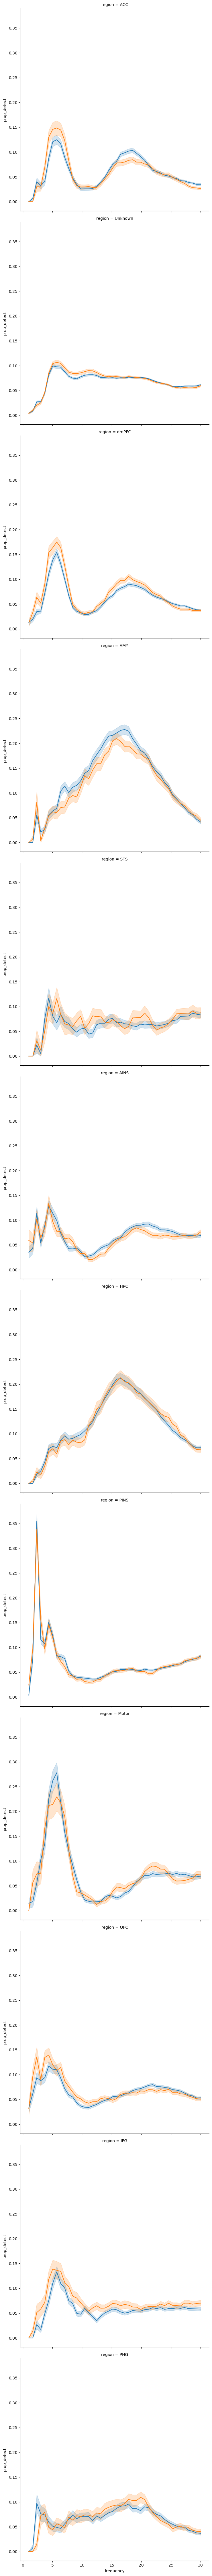

In [88]:
g = sns.FacetGrid(all_dfs, 
                  row='region', hue= 'rpe_cat', 
                  height=7.5, sharey=True, sharex=True)

g.map(sns.lineplot, "frequency", "prop_detect",  errorbar='se')

# sns.lineplot(data=all_dfs[all_dfs.rpe>0], x='frequency', y='prop_detect', errorbar='se')
# sns.lineplot(data=all_dfs[all_dfs.rpe<0], x='frequency', y='prop_detect', errorbar='se')

## Empirical mode decomposition for cycle/burst detection (WIP)

The benefit of EMD is that we get away from assumptions of sinuisoidal oscillations and linearity in the time-series. 

TODO: CURRENTLY DEPRECATED BC EMD PACKAGE CONFLICTS WITH MNE CONNECTVITIY PACKAGE. BLEGH!

In [2]:
# # Zscore the data first (idk why, but otherwise unable to plot IMFs) 

# test_epoch = zscore(feedback_epochs_reref._data[0, 26, :])
# time_vect = feedback_epochs_reref.times
# sample_rate = int(feedback_epochs_reref.info['sfreq'])
# plt.plot(time_vect, test_epoch)

<AxesSubplot:xlabel='Time (samples)'>

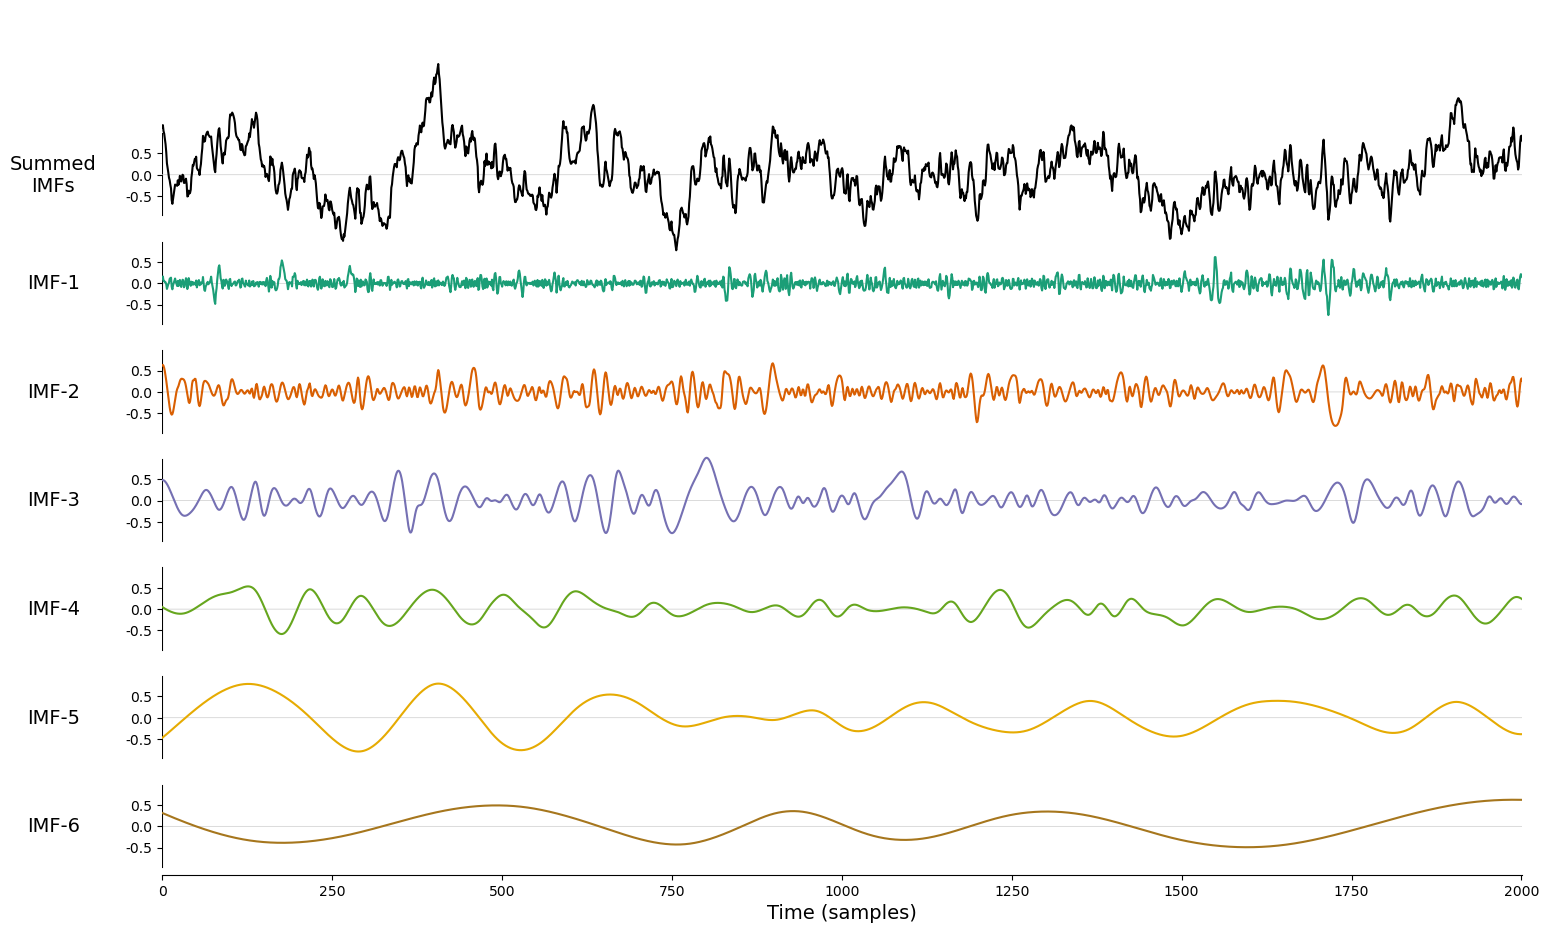

In [84]:
# imf = emd.sift.sift(test_epoch, max_imfs=6)
# # Visualise the IMFs
# emd.plotting.plot_imfs(imf)

Here, it looks like IMF-2 might have some meaningful oscillatory bursts in it

from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method

In [3]:
# IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
# # Extract cycle locations
# all_cycles = emd.cycles.get_cycle_vector(IP, return_good=False)
# good_cycles = emd.cycles.get_cycle_vector(IP, return_good=True)

# # ``all_cycles`` is an array of the same size as the input instantaneous phase.
# # Each row contains a vector of itegers indexing the location of successive
# # cycles for that IMF.

# # Set a 33% amplitude threshold on IMF-1 

# thresh = np.percentile(IA[:, 1], 33)
# mask = IA[:, 1] > thresh

# mask_cycles = emd.cycles.get_cycle_vector(IP, return_good=True, mask=mask)

In [10]:

# # Compute cycle average frequency for all cycles and masked cycles
# all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1], func=np.mean)
# mask_cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1], func=np.mean)

# # Compute cycle frequency range for all cycles and for masked cycles
# all_cycle_amp = emd.cycles.get_cycle_stat(all_cycles[:, 1], IA[:, 1], func=np.mean)
# mask_cycle_amp = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IA[:, 1], func=np.mean)

# # Make a summary figures
# plt.figure()
# plt.plot(all_cycle_freq, all_cycle_amp, 'o')
# plt.plot(mask_cycle_freq, mask_cycle_amp, 'o')
# plt.xlabel('Cycle average frequency (Hz)')
# plt.ylabel('Cycle average amplitude')
# plt.plot((9, 22), (thresh, thresh), 'k:')
# plt.legend(['All-cycles', 'Masked-cycles', 'Amp thresh'])

In [9]:
# # Compute cycle average frequency for all cycles and masked cycles
# all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1], func=np.mean)
# mask_cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1], func=np.mean)


# # Define a simple function to compute the range of a set of values
# def degree_nonlinearity(x):
#     return np.std((x - x.mean()) / x.mean())


# # Compute cycle freuquency range for all cycles and for masked cycles
# all_cycle_freq_don = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1],
#                                                func=degree_nonlinearity)
# cycle_freq_don = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1],
#                                            func=degree_nonlinearity)

# # Make a summary figures
# plt.figure()
# plt.plot(all_cycle_freq, all_cycle_freq_don, 'o')
# plt.plot(mask_cycle_freq, cycle_freq_don, 'o')
# plt.xlabel('Cycle average frequency (Hz)')
# plt.ylabel('Cycle IF don (Hz)')
# plt.legend(['All-cycles', 'Masked-cycles'])

In [88]:
# C = emd.cycles.Cycles(IP[:, 1])


In [89]:
# C.compute_cycle_metric('max_amp', IA[:, 1], func=np.max)
# # Compute the length of each cycle
# C.compute_cycle_metric('duration', IA[:, 1], len)


In [8]:
# df = C.get_metric_dataframe()
# print(df)

In [4]:
# from scipy import signal 
# fft_f, pxx_linear = signal.welch(test_epoch, fs=sample_rate, nperseg=512)

# # Summary figure
# plt.figure()
# plt.subplot(121)
# plt.plot(fft_f, pxx_linear)
# plt.title("Welch's Periodogram")
# # plt.xlim(0, 20)
# # plt.xticks(np.arange(10)*2)
# plt.grid(True)
# plt.xlabel('Frequency (Hz)')

# # Hilbert-Huang transform
# freq_range = (0, 256, 64)
# hht_f, spec_linear = emd.spectra.hilberthuang(IF, IA, freq_range, scaling='density', sum_imfs=False)

# plt.xlim(0, 60)
# plt.subplot(122)
# plt.plot(hht_f, spec_linear[:, 0])
# # plt.xticks(np.arange(10)*2)
# plt.grid(True)
# plt.title("Hilbert-Huang Transform")
# plt.xlabel('Frequency (Hz)')
# plt.xlim(0, 60)

In [5]:
# fft_f.shape

From the instantaneous frequency and amplitude, we can compute the Hilbert-Huang spectrum:



In [6]:
# # Define frequency range (low_freq, high_freq, nsteps, spacing)
# freq_range = np.logspace(*np.log10([4, 120]), num=20)
# f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

In [7]:
# fig = plt.figure(figsize=(10, 6))
# emd.plotting.plot_hilberthuang(hht, time_vect, f,
#                                time_lims=(-0.5, 1.5),
#                                fig=fig, log_y=True, cmap='RdBu_r')